# Data Science Project: Assessment 3

ID: 201479413

Name: Benjamin Jeffrey

This assessment has a 60% weight.

## Case study

Refer to the brief

## 1. Aims, objectives and plan (4 marks)

### a) Aims and objectives

The aim of this project is to analyse a dataset for a client. The analysis should be documented step by step in this Jupyter notebook. There will be three main parts to the code in addition to parts that are mainly for documentation purposes. The code parts are pre-processing the dataset, applying a classification technique and building a statistical model, and then trying a different classification technique for comparison. The report will also include an analysis of the performance of both models, with a recommendation to the client on which model to use. Lastly we will also reflect on the project and suggest future work that could be done to improve on the result of this project.

### b) Plan

Below a Gantt chart for the project is shown. This is a modified version that was updated due to the project deadline changing. The chart shows the approximate number of days we planned to spend for each task arranged into four groups.

![Gantt Chart](gantt.png)

## 2. Understanding the case study (4 marks)

### Case study analysis

The client, a bank, wants us to build a system that can detect which transactions are fraudulent and which are valid from their credit card transactions. Specifically, there are four goals we aim to achieve for the client using their dataset of credit card transactions.

1.	Build a prediction model that can classify each instance in the transactions dataset as either being fraudulent or valid. As stated previously we will try two different classification techniques to achieve this and compare their performance. In this project we will use a logistic regression model and a random forest model.


2.	False negative predictions are more costly for them than false positive predictions, so we aim to minimise false negatives when possible. We can achieve this by playing with the models class weights to influence the precision recall trade-off.


3.	The client is willing to accept 20 false positives per £100m valid transactions, so we will want to aim for less than that.


4.	The client is also willing to accept no more than 5 false negatives per £200k fraudulent transactions, so we also aim to stay in that margin.

## 3. Pre-processing applied (20 marks)


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from math import floor
from warnings import filterwarnings
from sklearn.feature_selection import f_classif, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from itertools import product, compress

filterwarnings(action='ignore')
pd.options.display.max_columns = 31
%config InlineBackend.figure_format ='retina'
mpl.style.use('ggplot')

### a) Preparing the labels appropriately

The code below shows the steps taken to prepare the labels for modelling. The
first step was to load the dataset and take a quick look at how the data is
structured.

In [2]:
df = pd.read_csv('creditcard.csv')
print(df.info(memory_usage=False))
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As we can see there are 284807 instances in the dataset with 31 attributes. We
can also see that there are no missing values in the dataset. All attributes
other than the target attribute `Class` are float attributes. Below code shows
the unique values of the `Class` attribute as well as their occurence count.

In [3]:
X = df.iloc[:,:-1]
y = df['Class']

print('Unique labels:', y.unique())
print(f'# Valid transactions: {y[y == 0].count()} [{y[y == 0].count() / y.size:.1%}]')
print(f'# Fraudulent transactions: {y[y == 1].count()} [{y[y == 1].count() / y.size:.1%}]')

Unique labels: [0 1]
# Valid transactions: 284315 [99.8%]
# Fraudulent transactions: 492 [0.2%]


There are two classes of transactions, normal ones and fraudulent ones. As the
`Class` attribute only contains 0s or 1s and is not missing any values, this
attribute is essentially ready for modelling as it is. There is a heavy
imbalance in the dataset towards valid transactions that make up 99.8% of the
dataset. This was to be expected however as fraudulent transactions would be
much rarer in practice. This did mean we wanted to look into over-/undersampling
to make the dataset more balanced and that we had to be careful when
interpreting the model performance.

### b) Dealing with missing values

As we already saw in the previous section, there are no missing values in the dataset.
So no further action was required on this front.

### c) Removing synonymous and noisy attributes

Next we wanted to have a look at the feature attributes. We first looked at
the correlation between features to see if there were any features that are
redundant due to high correlation. This could be a problem for some models, as
they could be affected negatively by multicollinearity. To get a quick visual
overview the code below creates a heatmap of the correlation between the feature
variables.

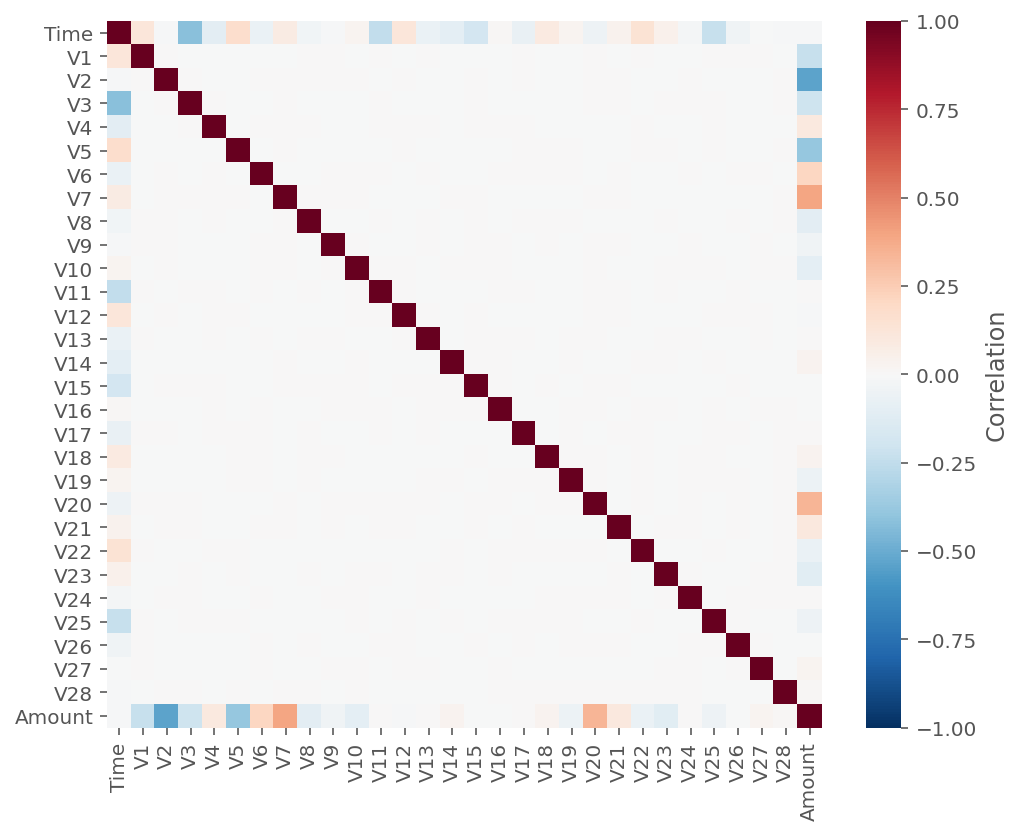

In [4]:
corr = X.corr()
plt.figure(figsize=(8, 6.5))
sns.heatmap(corr, cmap='RdBu_r', vmin=-1, vmax=1, annot=False,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values
            ).collections[0].colorbar.set_label('Correlation', size=12)
plt.yticks(rotation=0)
plt.show()

The heatmap above shows there is generally very little correlation between
features and no synonymous features exist. The 3 relationships with the highest
correlation can be seen below.

In [5]:
print('Amount/V2:', corr.loc['Amount']['V2'].round(2))
print('Time/V3:', corr.loc['Time']['V3'].round(2))
print('Amount/V7:', corr.loc['Amount']['V7'].round(2))

Amount/V2: -0.53
Time/V3: -0.42
Amount/V7: 0.4


With the highest correlation between features being 0.53 we did not see any need
to remove features due to multicollinearity.

Next we wanted to perform some feature selection to remove features that do not
contribute much to the classification task. As the feature attributes are
numerical, and the target attribute is categorical, we decided to analyse the
features by using the ANOVA correlation coefficient to evaluate how well each
feature can discriminate between the two classes. The below code calculates the
ANOVA F-values for each of the feature attributes.

In [6]:
fs_cols = []
for i, f_stat in enumerate(f_classif(X, y)[0]):
    if f_stat >= 1000:
        fs_cols.append(X.columns[i])
    print('{} - {:.1f}'.format(X.columns[i], f_stat))

Time - 43.3
V1 - 2955.7
V2 - 2393.4
V3 - 11014.5
V4 - 5163.8
V5 - 2592.4
V6 - 543.5
V7 - 10349.6
V8 - 112.5
V9 - 2746.6
V10 - 14058.0
V11 - 6999.4
V12 - 20749.8
V13 - 5.9
V14 - 28695.5
V15 - 5.1
V16 - 11443.3
V17 - 33979.2
V18 - 3584.4
V19 - 345.0
V20 - 115.0
V21 - 465.9
V22 - 0.2
V23 - 2.1
V24 - 14.9
V25 - 3.1
V26 - 5.7
V27 - 88.0
V28 - 25.9
Amount - 9.0


As is visible from the list above, there is a lot of spread in the F-values of
the ANOVA tests. Some values like `V22` seem very bad at distinguishing the two
classes, while `V17` is exceptionally proficient. Where we set the cut-off
point for which features to keep was a somewhat arbitrary decision, but from
looking at the data we thought keeping the best 14 features (F-values over 1000)
made sense to reduce the dimensionality by about half. The code above also saved
the column names of the 14 features with the highest ANOVA F-values in a list,
so we can easily select them when needed.

### d) Rescaling if necessary

Some tasks we aimed to perform, like regularisation on a logistic regression
model, required the dataset to be scaled so that none of the features can
overpower another. First we wanted to explore the range of the features to see
if scaling was required at all however. The below summary shows the min and max
values of each feature as well as some additional statistics.

In [7]:
pd.options.display.float_format = '{:.1f}'.format
X.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0,284807.0
mean,94813.9,0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0,-0.0,88.3
std,47488.1,2.0,1.7,1.5,1.4,1.4,1.3,1.2,1.2,1.1,1.1,1.0,1.0,1.0,1.0,0.9,0.9,0.8,0.8,0.8,0.8,0.7,0.7,0.6,0.6,0.5,0.5,0.4,0.3,250.1
min,0.0,-56.4,-72.7,-48.3,-5.7,-113.7,-26.2,-43.6,-73.2,-13.4,-24.6,-4.8,-18.7,-5.8,-19.2,-4.5,-14.1,-25.2,-9.5,-7.2,-54.5,-34.8,-10.9,-44.8,-2.8,-10.3,-2.6,-22.6,-15.4,0.0
25%,54201.5,-0.9,-0.6,-0.9,-0.8,-0.7,-0.8,-0.6,-0.2,-0.6,-0.5,-0.8,-0.4,-0.6,-0.4,-0.6,-0.5,-0.5,-0.5,-0.5,-0.2,-0.2,-0.5,-0.2,-0.4,-0.3,-0.3,-0.1,-0.1,5.6
50%,84692.0,0.0,0.1,0.2,-0.0,-0.1,-0.3,0.0,0.0,-0.1,-0.1,-0.0,0.1,-0.0,0.1,0.0,0.1,-0.1,-0.0,0.0,-0.1,-0.0,0.0,-0.0,0.0,0.0,-0.1,0.0,0.0,22.0
75%,139320.5,1.3,0.8,1.0,0.7,0.6,0.4,0.6,0.3,0.6,0.5,0.7,0.6,0.7,0.5,0.6,0.5,0.4,0.5,0.5,0.1,0.2,0.5,0.1,0.4,0.4,0.2,0.1,0.1,77.2
max,172792.0,2.5,22.1,9.4,16.9,34.8,73.3,120.6,20.0,15.6,23.7,12.0,7.8,7.1,10.5,8.9,17.3,9.3,5.0,5.6,39.4,27.2,10.5,22.5,4.6,7.5,3.5,31.6,33.8,25691.2


As is visible from the output above, the `Time` and `Amount` attributes have
vastly different ranges from the other features. If we ignore them for now, we
can visualise all the remaining features in a line chart using the code below.

In [ ]:
X.drop(['Time', 'Amount'], axis=1).plot(linewidth=0.1, legend=False, figsize=(15,7))
plt.show()

We can see from the plot that the rest of the features seem quite close to each
other in terms of range. As it is difficult to tell due to the overlapping, we
still decided to scale all features using min-max scaling to be thorough. We
did this by including sklearn's `MinMaxScaler` as part of the pipeline for
training the models and this can be seen in the next sections.

### e) Dealing with class imbalance

As we saw in section 3. a), the dataset is very imbalanced. For this reason we
also wanted to try if oversampling the minority class or undersampling the
majority class would improve model performance. This was also done as part of a
pipeline and can be seen in section 4. c).

## 4. Technique 1 (20 marks)

### a) Discuss your motivation for choosing the technique

For our first technique we decided to use a logistic regression model. This is a
classification algorithm that calculates the probability of success or failure
of an event. It is therefore very well suited for our binary classification
problem. Since this model is easy to build, train and interpret it is often the
go-to first choice for a problem of this kind. We can also use the model
coefficients to gain insights on the feature importance of our attributes and
perform further feature selection if necessary. It is also very simple to set up
using the sklearn library and provides quick results that we could build on and
makes it easy to add functionality like adding regularisation.

### b) Setting hyper parameters with rationale

For the hyperparameters of the logistic regression model we used a lot of the
default parameters first as they made sense for the problem we were tackling. In
detail, we used the `lbfsg` solver to find the optimal parameters and used
`l2` regularisation to ensure the model does not overfit. We set a higher
`max_iter` value though as the solver did not converge in all cases with the
default setting. The code below shows the setting up of a pipeline to scale
the features, and fit a logistic regression model using 5-fold cross validation.
Some performance metrics to evaluate the model's performance are then shown, as well as the average cost the client would incur due to misclassifications. The cost is based on the average cost of false negative and false positive predictions as set out in the client’s specification.

In [9]:
%%time
pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000, random_state=42))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_pred = cross_val_predict(pipe, X, y, cv=cv)

def print_metrics(y_test, y_pred):
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    print(f'Precision: {metrics.precision_score(y_test, y_pred):.2%},',
          f'Recall: {metrics.recall_score(y_test, y_pred):.2%},',
          f'F1-score: {metrics.f1_score(y_test, y_pred):.2%},',
          f'ROC-AUC-score: {metrics.roc_auc_score(y_test, y_pred):.2%},',
          f'Average-Cost: {fp*1000+fn*10000:,}£')
print_metrics(y, y_pred)

Precision: 86.97%, Recall: 54.27%, F1-score: 66.83%, ROC-AUC-score: 77.13%, Average-Cost: 2,290,000£
Wall time: 10.2 s


The above code shows the performance of the full dataset while the code below
shows the performance using the smaller dataset after performing feature
selection.

In [10]:
%%time
y_pred = cross_val_predict(pipe, X[fs_cols], y, cv=cv)

print_metrics(y, y_pred)

Precision: 86.56%, Recall: 53.66%, F1-score: 66.25%, ROC-AUC-score: 76.82%, Average-Cost: 2,321,000£
Wall time: 6 s


As we can see, using the smaller dataset we get almost equal performance at
half the training time. The execution time is not that drastically different however, so we
wanted to explore a different method of feature selection to the ANOVA approach
to see if we could fully match the performance of the full dataset. This time we
wanted to use recursive feature elimination to try different size subsets of
features and see how the performance changes based on the metrics we used above.
The features are selected based on the model coefficients. Below code shows the
results for all possible sizes of feature subsets on the dataset.

In [11]:
for i in range(len(X.columns)):
    selector = RFE(
        estimator=LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000, random_state=42),
        n_features_to_select=i+1
    )
    selector = selector.fit(MinMaxScaler().fit_transform(X), y)

    cols = list(compress(X.columns, selector.support_))

    y_pred = cross_val_predict(pipe, X[cols], y, cv=cv)

    print(f'{i+1} Features,',
          f'Precision: {metrics.precision_score(y, y_pred):.2%},',
          f'Recall: {metrics.recall_score(y, y_pred):.2%},',
          f'F1-score: {metrics.f1_score(y, y_pred):.2%},',
          f'ROC-AUC-score: {metrics.roc_auc_score(y, y_pred):.2%}')

1 Features, Precision: 82.07%, Recall: 30.69%, F1-score: 44.67%, ROC-AUC-score: 65.34%
2 Features, Precision: 84.88%, Recall: 44.51%, F1-score: 58.40%, ROC-AUC-score: 72.25%
3 Features, Precision: 85.98%, Recall: 47.36%, F1-score: 61.07%, ROC-AUC-score: 73.67%
4 Features, Precision: 86.83%, Recall: 49.59%, F1-score: 63.13%, ROC-AUC-score: 74.79%
5 Features, Precision: 86.71%, Recall: 50.41%, F1-score: 63.75%, ROC-AUC-score: 75.20%
6 Features, Precision: 86.87%, Recall: 52.44%, F1-score: 65.40%, ROC-AUC-score: 76.21%
7 Features, Precision: 86.91%, Recall: 52.64%, F1-score: 65.57%, ROC-AUC-score: 76.31%
8 Features, Precision: 87.33%, Recall: 53.25%, F1-score: 66.16%, ROC-AUC-score: 76.62%
9 Features, Precision: 87.58%, Recall: 53.05%, F1-score: 66.08%, ROC-AUC-score: 76.52%
10 Features, Precision: 87.42%, Recall: 53.66%, F1-score: 66.50%, ROC-AUC-score: 76.82%
11 Features, Precision: 87.46%, Recall: 53.86%, F1-score: 66.67%, ROC-AUC-score: 76.92%
12 Features, Precision: 87.46%, Recall: 5

From the output above we can see that performance does not increase with more
than 13 features. The code below saves a list of these 13 features so that we
can easily reduce the dataset to these features, which we did for the rest of
the modelling process with the logistic regression model.

In [11]:
selector = RFE(
    estimator=LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000, random_state=42),
    n_features_to_select=13
)
selector = selector.fit(MinMaxScaler().fit_transform(X), y)

fs_cols = list(compress(X.columns, selector.support_))
print(fs_cols)

['V4', 'V5', 'V6', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16', 'V17', 'V21']


### c) Optimising hyper parameters

To optimise the performance of the model we wanted to investigate different
methods of regularisation. To do this we used GridSearch to test different
parameters using cross validation to ensure we did not overfit the data. The code
below shows this method. We had to use a different solver, `saga`, that allows
all forms of regularisation supported by sklearn. We used the F1-score for the
ranking of the best parameters. Furthermore, this is also where we wanted to try
different amounts of under- and oversampling to see if this could increase model
performance.

In [12]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('oversampler', SMOTE(random_state=42)),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('model', LogisticRegression(solver='saga', l1_ratio=0.5, max_iter=2000, random_state=42))
])

tuner=GridSearchCV(
    estimator=pipe,
    param_grid={
        'oversampler__sampling_strategy': ['not minority', 0.1, 0.2, 0.35, 'not majority'],
        'undersampler__sampling_strategy': ['not minority', 0.1, 0.2, 0.35, 'not majority'],
        'model__penalty': ['none', 'l1', 'l2', 'elasticnet']
    },
    scoring='f1', n_jobs=-1, cv=cv
)

tuner.fit(X[fs_cols], y)

print(f"F1-score: {tuner.best_score_:.2%}")
print('Best parameters:', tuner.best_params_)

F1-score: 78.48%
Best parameters: {'model__penalty': 'l2', 'oversampler__sampling_strategy': 'not minority', 'undersampler__sampling_strategy': 0.1}


The output above shows that the best performance was achieved using
`l2`-regularisation and undersampling the majority class to bring the class
ratio of the training set to 90% valid transactions. The code below runs a
5-fold cross validation using the best parameters we have found so far.

Precision: 78.89%, Recall: 78.25%, F1-score: 78.57%, ROC-AUC-score: 89.11%, Average-Cost: 1,173,000£


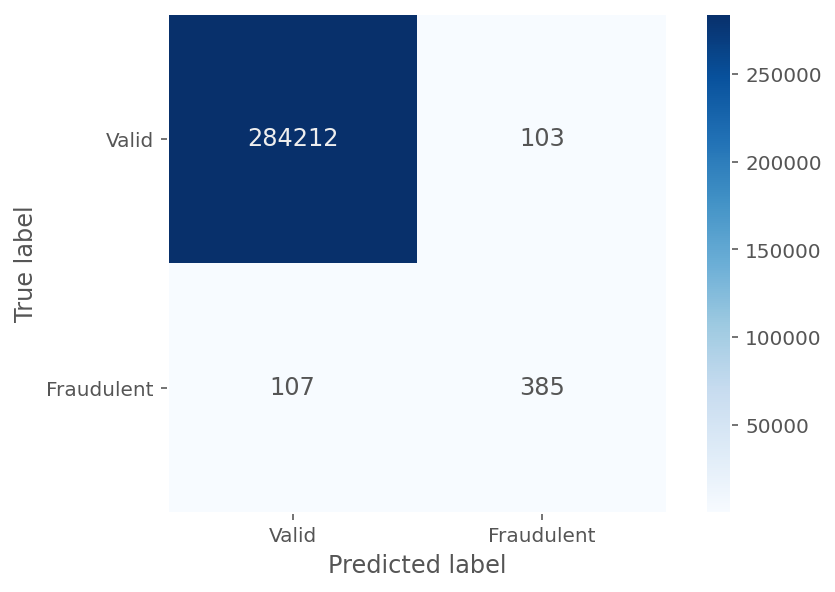

In [13]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('model', LogisticRegression(solver='lbfgs', penalty='l2', max_iter=2000, random_state=42))
])

y_pred = cross_val_predict(pipe, X[fs_cols], y, cv=cv)

print_metrics(y, y_pred)

def plot_cm(cm, class_names):
    plt.figure(figsize=(6, 4))
    plt.grid(b=False)
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    threshold = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), size=12, horizontalalignment='center',
                 verticalalignment='center', color="#eeeeee" if cm[i, j] > threshold else '#555555')

    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
plot_cm(metrics.confusion_matrix(y, y_pred), ['Valid', 'Fraudulent'])

The output above shows the usual performance metrics as well as the confusion
matrix for all 5 folds of cross validation. Since each instance of the dataset
is partitioned to be used once as a test instance during the cross validation,
the matrix shows the true negatives, false positives, false negatives and true
positives of the entire dataset. We can see that of all instances the model made
103 false positive predictions and 107 false negative predictions.

According to their specifications the client is willing to allow a budget of no
more than £20k false positives for each £100m valid transactions and £50k false
negatives for each £200k fraudulent transactions. The code below calculates the
allowed false positives and false negatives fot the entire dataset given these
specifications, and the transaction volume recorded in the dataset.

In [14]:
allowed_fp = floor(df[y == 0]['Amount'].sum() / 100000000 * 20)
allowed_fn = floor(df[y == 1]['Amount'].sum() / 200000 * 5)

print(f'Max. false positives allowed: {allowed_fp}')
print(f'Max. false negatives allowed: {allowed_fn}')

Max. false positives allowed: 5
Max. false negatives allowed: 1


The specification only allows for 5 false positives and 1 false negative for the
entire dataset. This is basically impossible even for the best of models. As we
can see from the confusion matrix above, we have so far managed to reduce the
number of false predictions down to 210 out of 284,807. The clients requirements
indicate that higher importance should be given to minimising false negatives
over false positives however. The code below repeats the cross validation, but
we changed the `class_weight` parameter to shift the focus on minimising false
negatives.

Precision: 48.42%, Recall: 83.94%, F1-score: 61.41%, ROC-AUC-score: 91.89%, Average-Cost: 1,230,000£


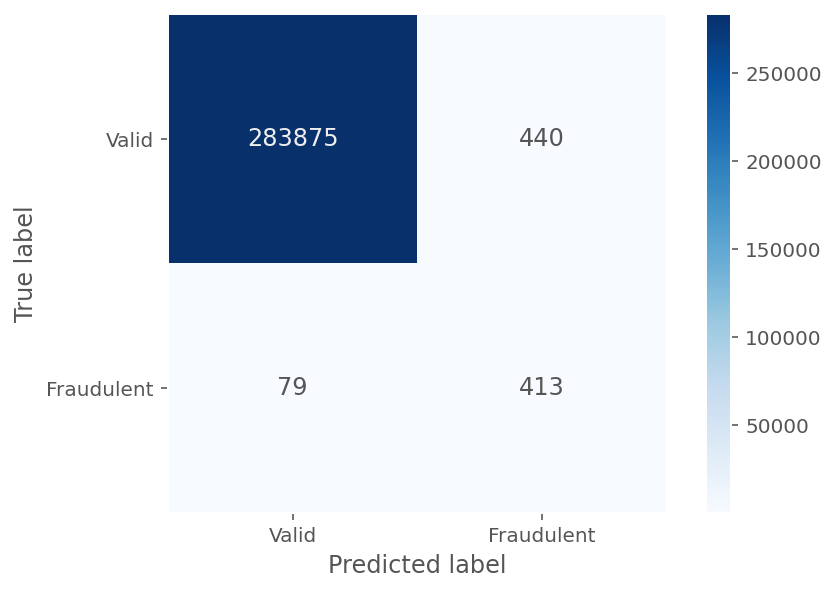

In [15]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('model', LogisticRegression(
        solver='lbfgs', penalty='l2', max_iter=2000, class_weight={0: 0.1, 1: 0.9}, random_state=42
    ))
])

y_pred = cross_val_predict(pipe, X[fs_cols], y, cv=cv)

print_metrics(y, y_pred)
plot_cm(metrics.confusion_matrix(y, y_pred), ['Valid', 'Fraudulent'])

The output above shows we were able to shift the focus of the model to
minimising false negatives with the confusion matrix now showing roughly the 5
to 1 ratio of false positives to false negatives set by the specification.
However, this shift is mostly due to increases in false positives with the false
negatives only reducing slightly. Due to this, the average cost we expect from the misclassifications is actually higher with the second model. We tried playing with the `class_weight` parameter more to find the model that minimises the expected cost, the result of which can be seen below.

Precision: 72.35%, Recall: 81.91%, F1-score: 76.84%, ROC-AUC-score: 90.93%, Average-Cost: 1,044,000£


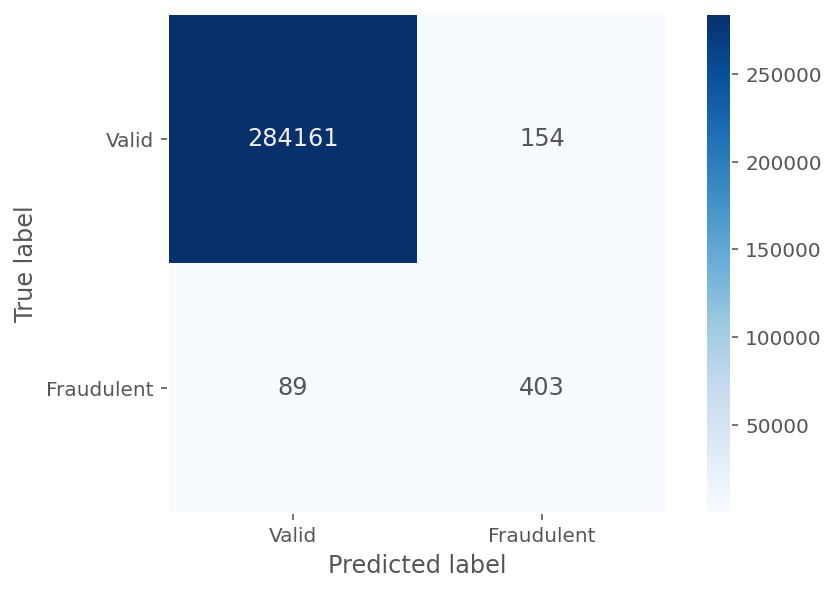

In [16]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('undersampler', RandomUnderSampler(sampling_strategy=0.1, random_state=42)),
    ('model', LogisticRegression(
        solver='lbfgs', penalty='l2', max_iter=2000, class_weight={0: 0.18, 1: 0.82}, random_state=42
    ))
])

y_pred = cross_val_predict(pipe, X[fs_cols], y, cv=cv)
y_pred_lr =y_pred

print_metrics(y, y_pred)
plot_cm(metrics.confusion_matrix(y, y_pred), ['Valid', 'Fraudulent'])

### d) Performance metrics for training

Throughout the previous sections we have reported the model performance using 6
metrics, precision, recall, F1-score, ROC-AUC-score, Average-Cost and the confusion matrix.
The precision and recall metrics provide information on how well the model
minimises false positives and false negatives respectively. The F1-score and
ROC-AUC-score are holistic metrics that indicate general model performance. We
deliberately did not use accuracy due to the heavily skewed dataset. The
F1-score and ROC-AUC-score are far more robust for skewed datasets. The code
below plots the ROC curve for the best model, using the `class_weight` that minimised the expected cost,
to help visualise the model performance.

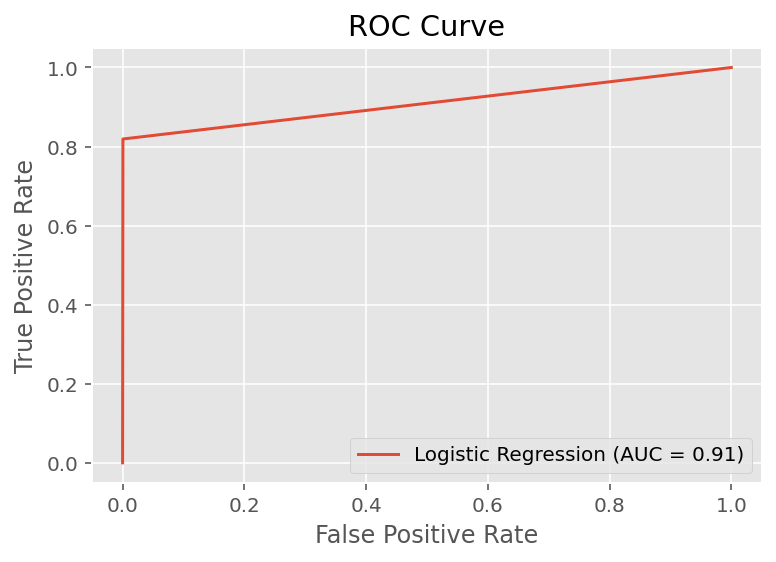

In [17]:
metrics.RocCurveDisplay(
    fpr=metrics.roc_curve(y, y_pred_lr)[0], tpr=metrics.roc_curve(y, y_pred_lr)[1],
    roc_auc=metrics.roc_auc_score(y, y_pred_lr), estimator_name='Logistic Regression'
).plot()
plt.title('ROC Curve')
plt.show()

## 5. Technique 2 (20 marks)

### a) Discuss your motivation for choosing the technique

The random forest classifier is an ensemble method of classification. It is based on the idea that many actors will always come up with better predictions than one acting on its own. Random forests combine many decision tree models in order to build the best possible model. This has some advantages and disadvantages. Performance can often be higher with random forest due to the ensembling and there is also a reduced chance of overfitting since different bootstrap samples are used to generate the trees. However, they do take long to train and finding the right hyperparameters can be very costly due to the many options and training time. We decided it was worth the effort though to build a better model than the logistic regression model we tried so far.

### b) Optimising hyper parameters

As a random forest model has many hyperparameters to tune we decided to use
`GridSearchCV` again to find the optimal parameters for our problem. We used the
full dataset for this as random forests perform feature selection natively by
deciding which features to split on, and we did not want to restrict the options
unnecessarily. The code below performs the grid search for various model
parameters as well as under-/oversampling.

In [80]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('oversampler', SMOTE(random_state=42)),
    ('undersampler', RandomUnderSampler(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

tuner=GridSearchCV(
    estimator=pipe,
    param_grid={
        'oversampler__sampling_strategy': ['not minority', 0.1, 0.2, 'not majority'],
        'undersampler__sampling_strategy': ['not minority', 0.1, 0.2, 'not majority'],
        'model__n_estimators': [20, 50, 100],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [5, 10, 20, 50],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__max_features': [1, 2, 4, 6]
    },
    scoring='f1', n_jobs=-1, cv=cv
)

tuner.fit(X, y)

print(f'F1-score: {tuner.best_score_:.2%}')
print('Best parameters:', tuner.best_params_)

F1-score: 86.66%
Best parameters: {'model__criterion': 'gini', 'model__max_depth': 20, 'model__max_features': 4, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 20, 'oversampler__sampling_strategy': 0.1, 'undersampler__sampling_strategy': 'not majority'}


From the output above we can see the model parameters that achieved the highest
F1-score. We can also see that this time we achieved better performance by
oversampling using `SMOTE` than undersampling like with the logistic regression
model. The oversampling was again applied to bring the minority class up to 10%
share of the dataset.

The code below fits a random forest model with the optimal parameters we
discovered and outputs the usual performance metrics and confusion matrix.

Precision: 89.65%, Recall: 82.72%, F1-score: 86.05%, ROC-AUC-score: 91.35%, Average-Cost: 897,000£


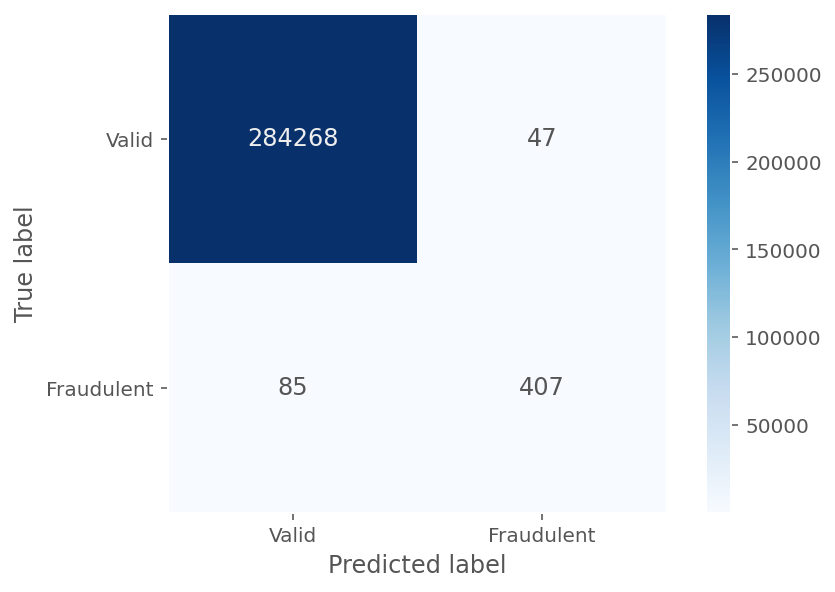

In [18]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('oversampler', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=20, criterion='gini', max_depth=20, min_samples_split=2,
        min_samples_leaf=1, max_features=4, n_jobs=-1, random_state=42
    ))
])

y_pred = cross_val_predict(pipe, X, y, cv=cv)

print_metrics(y, y_pred)
plot_cm(metrics.confusion_matrix(y, y_pred), ['Valid', 'Fraudulent'])

As with the logistic regression model, the random forest made more false
negative predictions than false positive ones. We tried to adjust the
`class_weight` parameter again to achieve roughly a 5 to 1 ratio of false positives to false negatives using
the code below.

Precision: 58.49%, Recall: 83.33%, F1-score: 68.73%, ROC-AUC-score: 91.62%, Average-Cost: 1,111,000£


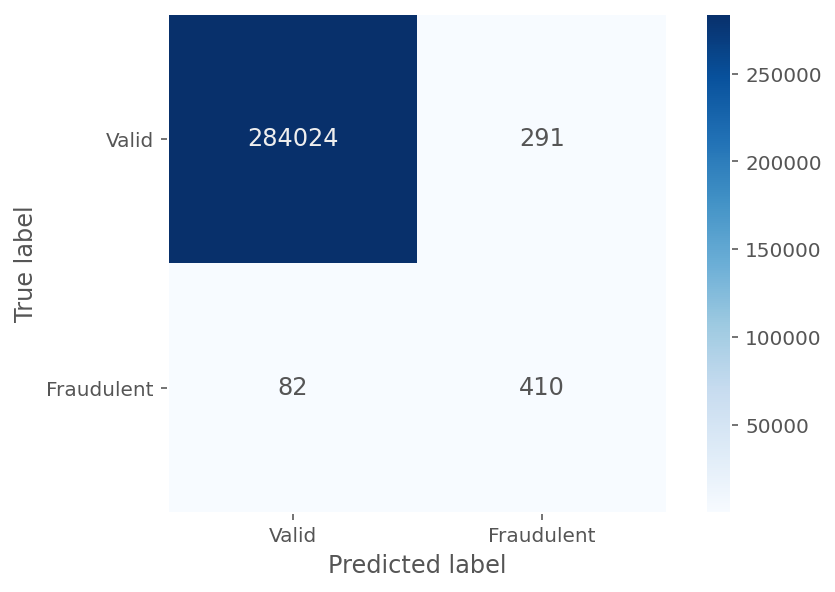

In [19]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('oversampler', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=20, criterion='gini', max_depth=20, min_samples_split=2,
        min_samples_leaf=1, max_features=4, class_weight={0: 0.02, 1: 0.98},
        n_jobs=-1, random_state=42
    ))
])

y_pred = cross_val_predict(pipe, X, y, cv=cv)

print_metrics(y, y_pred)
plot_cm(metrics.confusion_matrix(y, y_pred), ['Valid', 'Fraudulent'])

As we saw with the logistic regression model, the false negatives only decrease very marginally while the false positives increase substantially, leading to an increased expected cost for the misclassifications. Given this, it made little sense to apply the modified `class_weight` like this and we tried to find the paramater setting that minimised the cost instead. The code for this can be seen below.

Precision: 90.04%, Recall: 82.72%, F1-score: 86.23%, ROC-AUC-score: 91.35%, Average-Cost: 895,000£


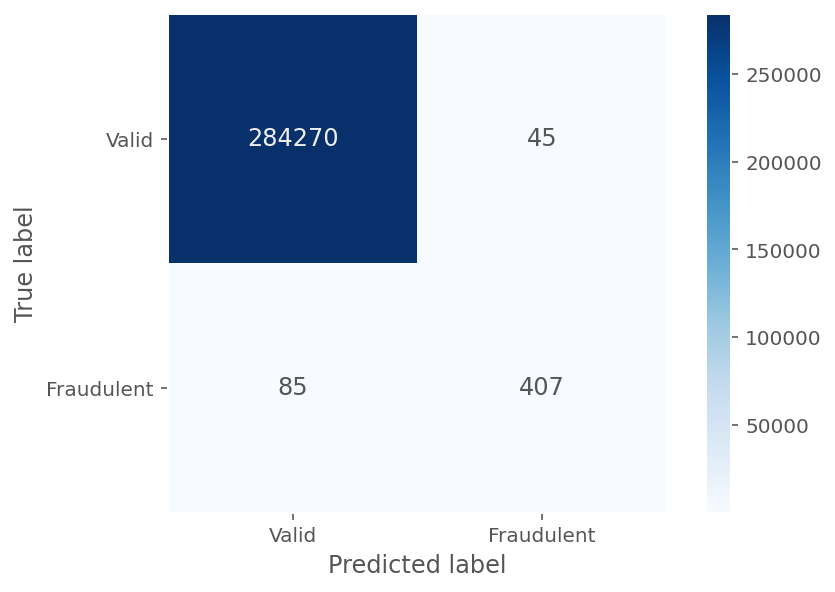

In [20]:
pipe = ImbPipeline([
    ('scaler', MinMaxScaler()),
    ('oversampler', SMOTE(sampling_strategy=0.1, random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=20, criterion='gini', max_depth=20, min_samples_split=2,
        min_samples_leaf=1, max_features=4, class_weight={0: 0.22, 1: 0.78},
        n_jobs=-1, random_state=42
    ))
])

y_pred = cross_val_predict(pipe, X, y, cv=cv)
y_pred_rf = y_pred

print_metrics(y, y_pred)
plot_cm(metrics.confusion_matrix(y, y_pred), ['Valid', 'Fraudulent'])

### c) Performance metrics for training

We used the same performance metrics in this section as we did with the logistic regression model to make comparisons as easy as possible. The below code plots the ROC curve for the last model we built.

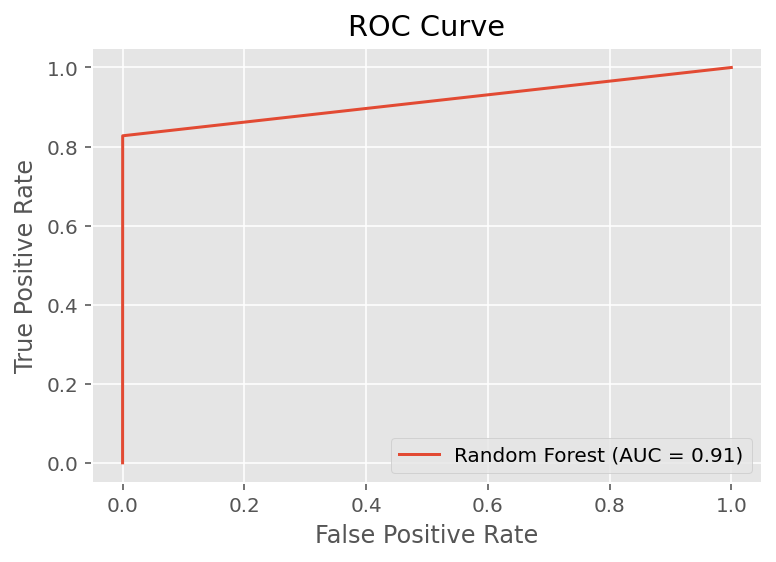

In [21]:
metrics.RocCurveDisplay(
    fpr=metrics.roc_curve(y, y_pred_rf)[0], tpr=metrics.roc_curve(y, y_pred_rf)[1],
    roc_auc=metrics.roc_auc_score(y, y_pred_rf), estimator_name='Random Forest'
).plot()
plt.title('ROC Curve')
plt.show()

## 6. Comparison of metrics performance for testing (16 marks)

### a) Use of cross validation for both techniques to deal with over-fitting

We have used cross validation throughout this project to ensure we did not overfit on the training data. As cross validation splits the dataset into partitions and then tests on each of them once while using the remainder as training data, the results are highly trustworthy, since we are always testing on unseen data. This is also the reason we used pipelines to perform our testing, to make sure the scaling parameters are only derived from the training data and that the under-/oversampling also is only applied to the training data.

### b) Comparison with appropriate metrics for testing

The code below shows an overview of the best performing models from section 4 and 5, so we can better compare them.

In [22]:
pd.DataFrame(
    data=[
        [f'{metrics.precision_score(y, y_pred_lr):.2%}', f'{metrics.precision_score(y, y_pred_rf):.2%}'],
        [f'{metrics.recall_score(y, y_pred_lr):.2%}', f'{metrics.recall_score(y, y_pred_rf):.2%}'],
        [f'{metrics.f1_score(y, y_pred_lr):.2%}', f'{metrics.f1_score(y, y_pred_rf):.2%}'],
        [f'{metrics.roc_auc_score(y, y_pred_lr):.2%}', f'{metrics.roc_auc_score(y, y_pred_rf):.2%}'],
        [f'{metrics.confusion_matrix(y, y_pred_lr)[0][1]*1000+metrics.confusion_matrix(y, y_pred_lr)[1][0]*10000:,}£',
         f'{metrics.confusion_matrix(y, y_pred_rf)[0][1]*1000+metrics.confusion_matrix(y, y_pred_rf)[1][0]*10000:,}£']
    ],
    columns=['Logistic Regression', 'Random Forest'],
    index=['Precision', 'Recall', 'F1-score', 'ROC-AUC-score', 'Average-Cost']
)

,Logistic Regression,Random Forest
Precision,72.35%,90.04%
Recall,81.91%,82.72%
F1-score,76.84%,86.23%
ROC-AUC-score,90.93%,91.35%
Average-Cost,"1,044,000£","895,000£"


As we can see the random forest model performed better across all metrics we used to evaluate model performance. We saw that we can tweak the model to prioritise minimising false negatives which changes the balance between precision and recall. By adjusting the `class_weight` parameter we were able to get a higher recall score than the precision score for both models. However, pushing this to far was not advisable due to the precision dropping drastically for small increases in the recall score. In our opinion the most important difference between the models is the lower expected cost from the misclassifications though, as this is likely what the client will care about most.

### c) Model selection (ROC or other charts)

As we saw before, we can visualise the ROC-AUC score by plotting the ROC curve. The code below plots the ROC curve for both the logistic regression model and the random forest model, showing the very slightly better performance of the random forest on the ROC-AUC score.

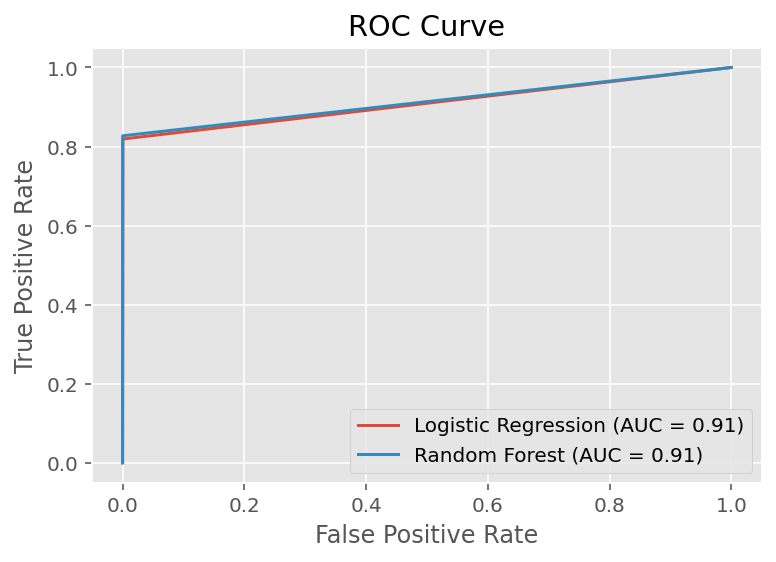

In [23]:
plt.plot(metrics.roc_curve(y, y_pred_lr)[0], metrics.roc_curve(y, y_pred_lr)[1],
         label=f'Logistic Regression (AUC = {metrics.roc_auc_score(y, y_pred_lr):.2})')
plt.plot(metrics.roc_curve(y, y_pred_rf)[0], metrics.roc_curve(y, y_pred_rf)[1],
         label=f'Random Forest (AUC = {metrics.roc_auc_score(y, y_pred_rf):.2})')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.show()

## 7. Final recommendation of best model (8 marks)

### a) Discuss the results from a technical perspective, for example, overfitting discussion, complexity and efficiency

The random forest model is clearly the better model in terms of performance. It is a much more complex model though and comes with a higher computational cost for training. However, unless the gridsearch is repeated, just training the model with the hyperparameters we discovered does not take substantially longer using up to date hardware. Neither model is likely to overfit as we used l2-regularisation for the logistic regression and random forests are less susceptible to overfitting natively. We also used cross validation for all of our evaluation, which did not indicate any issues with overfitting. We would recommend using the random forest model to the client from a technical perspective, as it does perform better and the drawbacks, such as the higher complexity, are very minor.

### b) Discuss the results from a business perspective, for example, results interpretation, relevance and balance with technical perspective

The random forest model is mostly a black box where the decisions made by the model cannot be easily interpreted. The trees of the forest could be visualised of course, but analysing all of them to understand what the model is doing is unfeasible in most cases. The logistic regression model on the other hand has model coefficients that can be accessed and would allow the interpretation of a specific decision.  So, if an analyst working on the detection of fraudulent transactions wants to understand why a certain case was not discovered by the model for instance, he could use the model coefficients to gain insight into which features led to the decision. Due to this, it depends on what the use case of the client is. If interpretability is of high value to them then we would recommend using the logistic regression model despite its somewhat slightly classification performance.

## 8. Conclusion (8 marks)

### a) What has been successfully accomplished and what has not been successful?

We have successfully accomplished in building a prediction system that can classify transactions as being fraudulent or valid most of the time. Our best model achieved an F1 score of 86.23%, while classifying 407 out of 492 fraudulent transactions correctly and 284,270 out of 284,315 valid transactions correctly. We fell short of the client’s acceptable limits for false negatives and false positives by a wide margin, however. Most likely there were some communication errors leading to different interpretations of the specifications, as the threshold for false negatives and false positives we calculated given the dataset are extremely low and well outside the reach of the models we tried.

### b) Reflecting back on the analysis, what could you have done differently if you were to do the project again?

Having a standardised setup from the beginning using pipelines to fit the models and make predictions would have cut down on the time we spent modelling significantly. We often went back to the beginning to redo everything because we decided maybe feature scaling or feature selection would help or rebalancing the dataset using under-/oversampling. That being said, it was a matter of trial and error in the end and performing many tests is part of the process. Switching to using pipelines helped with speeding up the process though which we would do from the beginning in the future.

### c) Provide a wish list of future work that you would like to do

Seeing as the client’s performance goals were not achieved in this project it would definitely be interesting to take the modelling further to see how low the average cost of misclassifications could be pushed. Trying a more complex model like a deep neural network would be an interesting approach, though we suspect the client’s goals could not be achieved using the provided dataset. Another approach therefore would be to try and gather more data, specifically on fraudulent transactions, since the provided dataset is heavily imbalanced. Finally, the sensible first step would be to reach out to the client and discuss the projects future and specifically their performance expectations, as judging by this project they seem somewhat unrealistic.

In [24]:
%%HTML
<link href="https://fonts.googleapis.com/css2?family=Open+Sans:ital,wght@0,300;0,400;0,600;0,700;0,800;1,300;1,400;1,600;1,700;1,800&display=swap" rel="stylesheet">
<style>
div.text_cell {
    padding-right: 10.65rem;
}
div.code_cell {
    padding-right: 9rem;
    margin-left: -2.3rem;
}
div.text_cell, div.output_subarea.output_html.rendered_html.output_result {
    font-family: 'Open Sans', sans-serif;
}
div.text_cell p, div.text_cell li {
    font-size: 1.6rem;
    font-weight: 300;
    text-align: justify;
}
div.text_cell h4 {
    font-size: 1.6rem;
}
</style>

# Used for styling Jupyter notebook. Will most likely not work with other programs.